# Plummer sphere analysis
Group work

In [1]:
import matplotlib
import numpy as np
import scipy
import random
import os
import time
import glob
import pandas as pd
import scipy.integrate as integrate
import scipy.special as special
from matplotlib import rcParams
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

In [25]:
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
%config InlineBackend.figure_format='retina'

## Reading data

In [26]:
M = 1
N = 5*10**4 #da cambiare in base ai dati da analizzare
b = 1
m = M/N
G = 1
filename = glob.glob('data/outdata*')
print(filename)

['data/outdata_5e4_0.2_0.0625.txt', 'data/outdata_8e4_0.3_0.0625.txt', 'data/outdata_10000_0.1_0.03125.txt', 'data/outdata_10000_0.15_0.03125.txt']


In [27]:
lines = pd.read_csv(filename[0], names = list(range(3)), sep = '\s+')
N_particles = N
s = N*3+3

t_s  = np.array([lines.iloc[2::s,0].copy().dropna()]).flatten()
m_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(3, N+3)])
x_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(N+3, 2*N+3)])
y_s  = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(N+3, 2*N+3)])
z_s  = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(N+3, 2*N+3)])
vx_s = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(2*N+3, 3*N+3)])
vy_s = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(2*N+3, 3*N+3)])
vz_s = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(2*N+3, 3*N+3)])
#calcolo raggi
r = np.sqrt(x_s**2 + y_s**2 + z_s**2)

# Lagrangian radius


The lagrangian radius is defined as?

In [28]:
# notice: radius_array must be of shape [N_particles, N_time_output]
def Lagrangian_Radius(radius_array, quantile):
    
    L_radii = []
    
    # cycle over N_time_output
    for i in range(len(radius_array[0])):
        
        radii_sorted = np.sort(radius_array[:,i])
        mask = radii_sorted < np.quantile(radii_sorted, quantile)
        L_radii.append(np.max(radii_sorted[mask]))
        
    return np.array(L_radii)

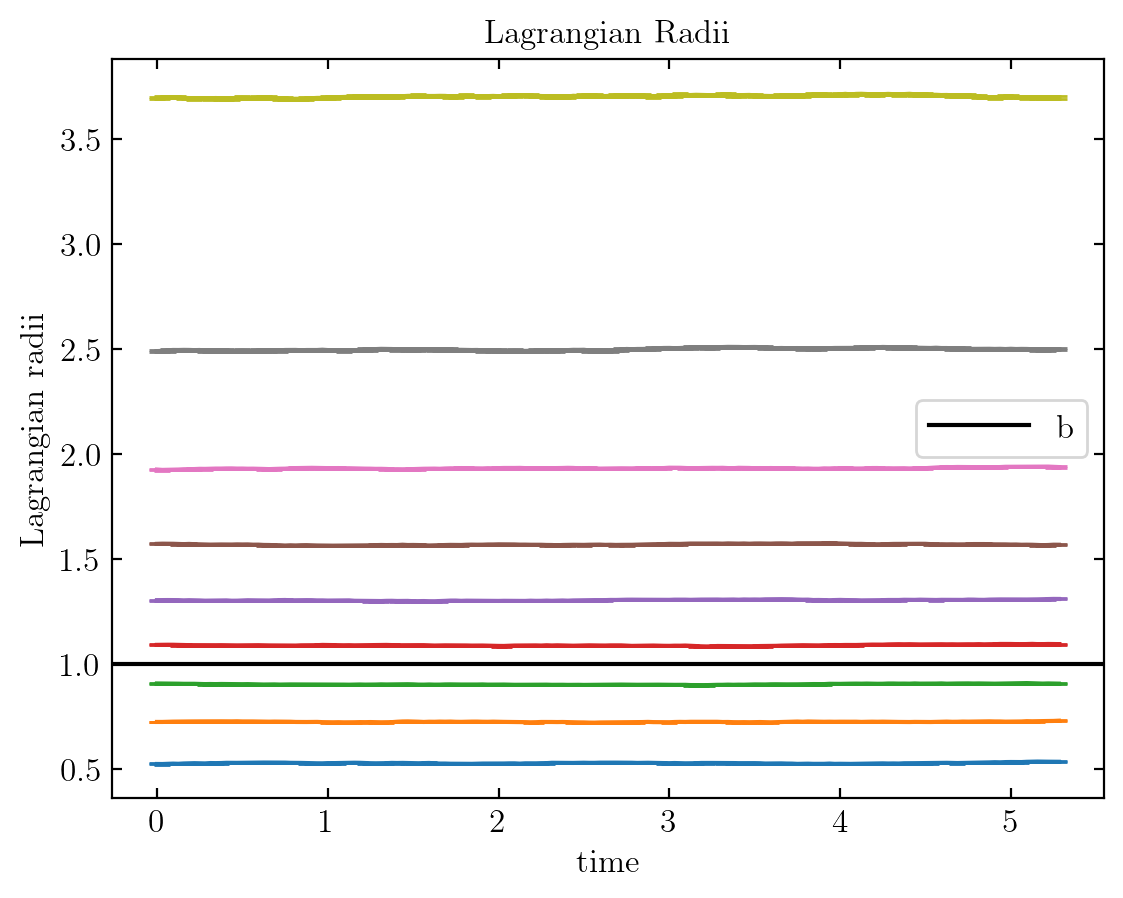

In [33]:
quantiles = np.linspace(0.1, 0.9, 9)

std = []

for q in quantiles:
    
    L = Lagrangian_Radius(r, round(q,1))
    std.append(np.var(L)**0.5)
    
    #plt.plot(t_s, L, label='q ='+str(round(q,1)))
    plt.errorbar(t_s, L, yerr=std[-1], xerr=None)   
    
plt.axhline(b, label='b', color='black')
plt.ylabel('Lagrangian radii')
plt.xlabel('time')
plt.title('Lagrangian Radii')
plt.margins(.05)
plt.legend()

# CoM

Here we show how the center of mass changes position with time

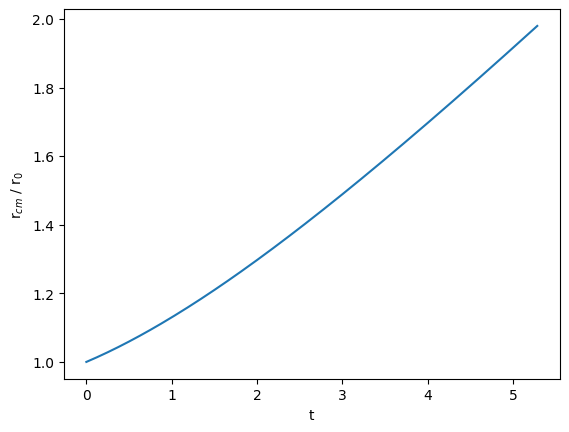

In [13]:
mu = m / M

x_cm = mu * np.sum(x_s, axis = 0)
y_cm = mu * np.sum(y_s, axis = 0)
z_cm = mu * np.sum(z_s, axis = 0)
r_cm = np.sqrt(x_cm**2 + y_cm**2 + z_cm**2)

plt.plot(t_s, r_cm/r_cm[0])
plt.ylabel('r$_{cm}$ / r$_{0}$')
plt.xlabel('t');

# Density profile

In [34]:
r_t   = np.transpose(r)
sampl = 1000
alpha = b/100
p_error = []
X     = np.linspace(b/5, 3 * b, sampl)
rho_t = []
for i in range(len(r_t)):
    rho = []
    tmp_err = []
    for x in X:
        dr      = alpha * x 
        r_min   = (x - dr/2)
        r_max   = (x + dr/2) 
        V_shell = 4 * np.pi * dr * x**2 #Calcolo i volume della shell
        mask    = (r_t[i] > r_min) * (r_t[i] < r_max) # prendo i raggi compresi tra r_min e r_max
        n       = len(r_t[i][mask])
        rho.append(n * m / V_shell) #len(r_t[i][mask] è il numero di particelle dentro la shell
        tmp_err.append(np.sqrt(n)*m/V_shell)
    rho_t.append(rho)
    p_error.append(tmp_err)

In [35]:
p_error = np.array(p_error)
tmp_err = np.array(tmp_err)
rho_t = np.array(rho_t) # densità a diversi tempi
rho = np.array(rho) #denisità a tempo = T_sim
rho_th = 3* M /(4*np.pi*b**3) * 1/(1+(X**2/b**2))**(5/2)
rho_c = 3* M /(4*np.pi*b**3) #densità centrale

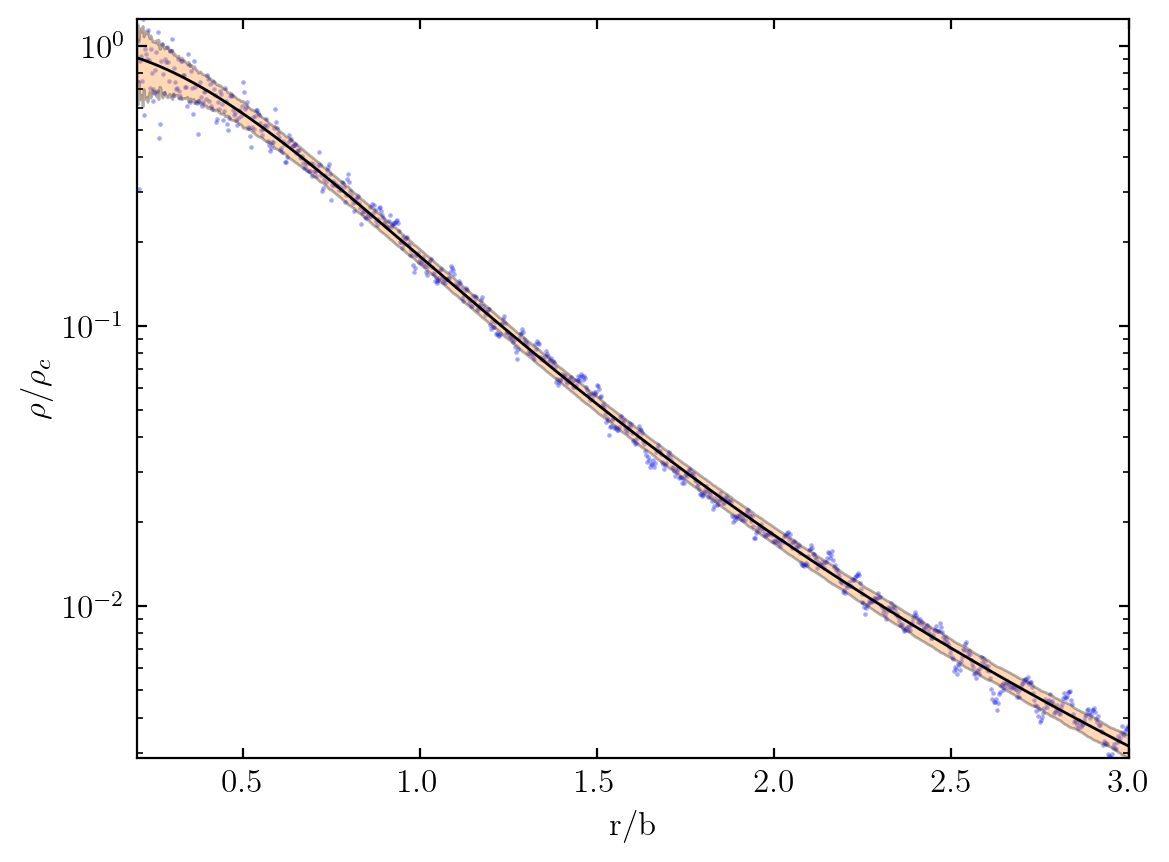

In [43]:
#plot della singola misura a T = T_sim. Normalizzo alla densità centrale 
t=len(rho_t)-1

plt.scatter(X,rho_t[t]/rho_c, s=0.5, alpha = .3)
plt.plot(X,rho_th/rho_c, '-k', lw=1) 
plt.fill_between(X, rho_th/rho_c - p_error[t]/rho_c, rho_th/rho_c + p_error[t]/rho_c, alpha= 0.3)
plt.yscale('log')
plt.ylabel(r'$\rho/ \rho_{c}$')
plt.xlabel('r/b')
plt.savefig(f'density_profile_t={t}.png')

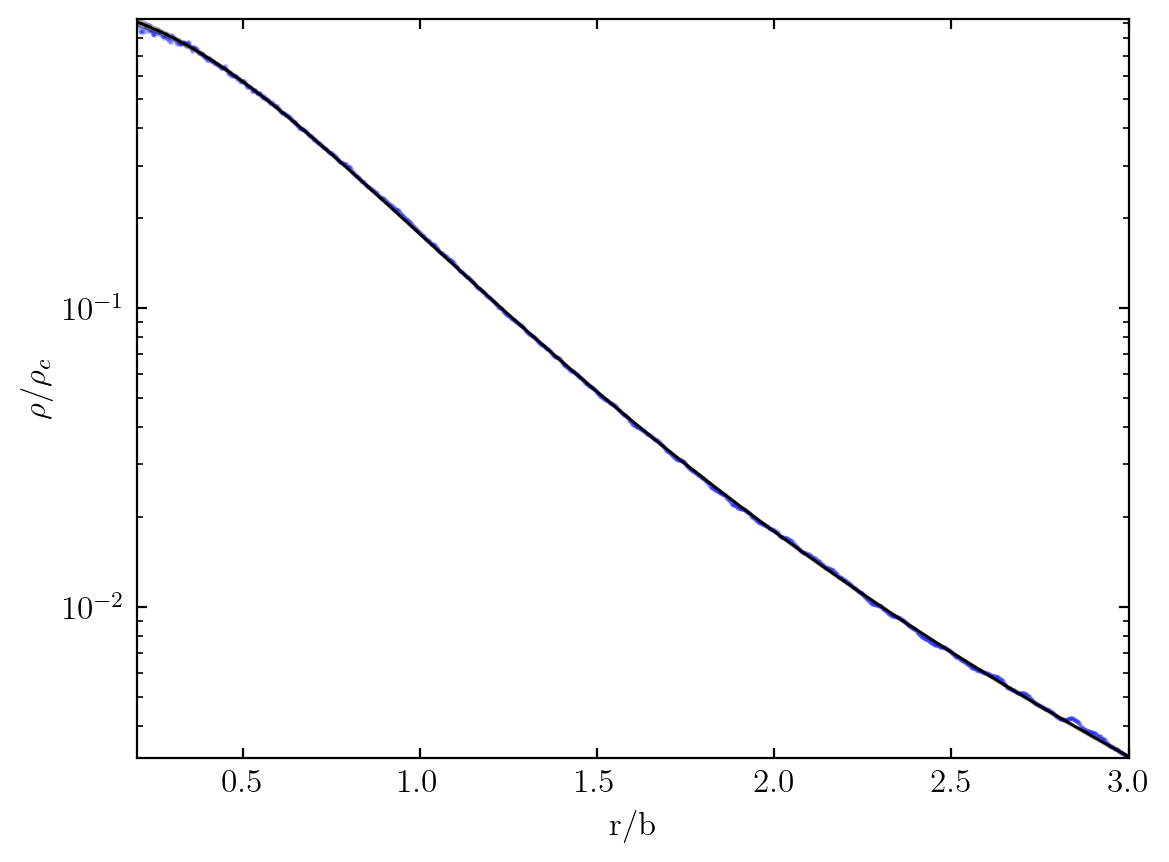

In [46]:
#Faccio la media sui tempi (è come se prendessi più misure del profilo di densità)
#I dati dovrebbero convergere alla distribuzione teorica
#Normalizzo per la rho_c
rho_mean = np.mean(rho_t,axis=0)
error = p_error[t]/np.sqrt(len(rho_t))
plt.scatter(X,rho_mean/rho_c, s=0.5, alpha = .3)
plt.plot(X,rho_th/rho_c, '-k', lw=1) 
plt.fill_between(X/b, rho_th/rho_c - error/rho_c, rho_th/rho_c + error/rho_c, alpha= 0.3)
plt.yscale('log')
plt.ylabel(r'$\rho/ \rho_{c}$')
plt.xlabel('r/b')
plt.savefig(f'density_profile_t={t}_mean.png')

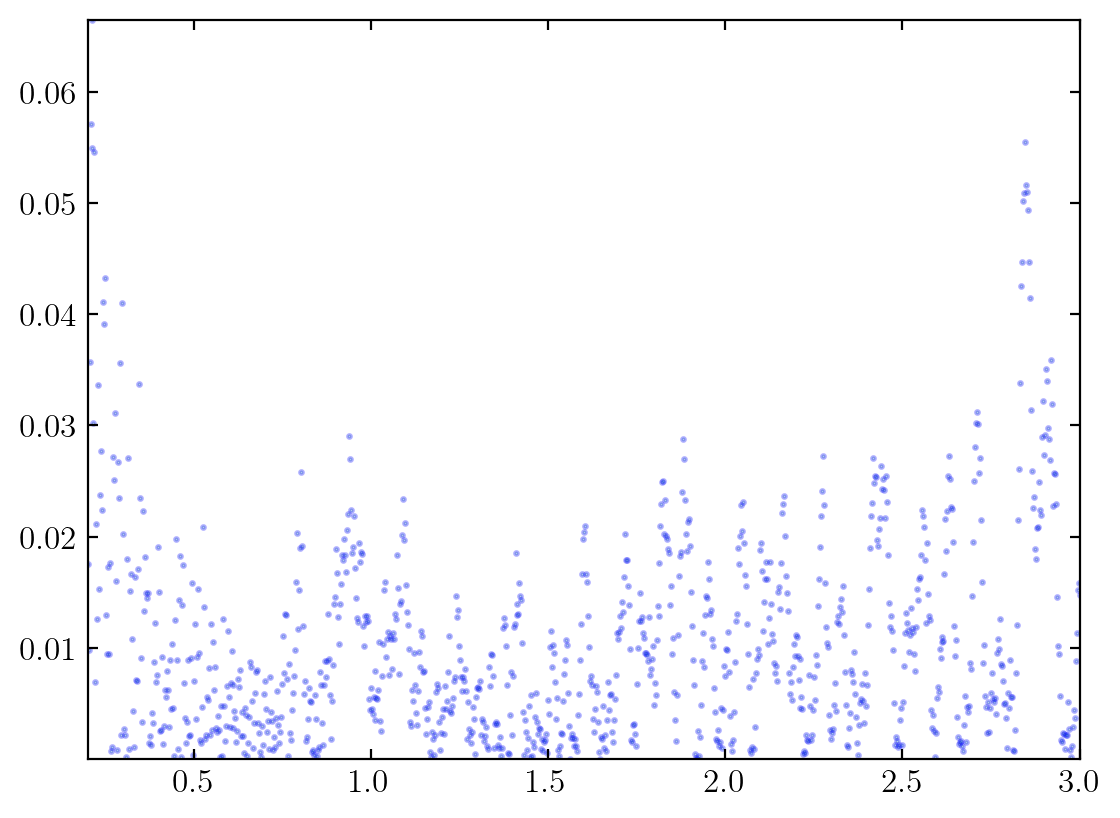

In [52]:
err= np.abs(rho_mean - rho_th) /rho_th
plt.scatter(X,err, s=2, alpha = .3);
#plt.yscale('log')